Preview (top rows):
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  eu

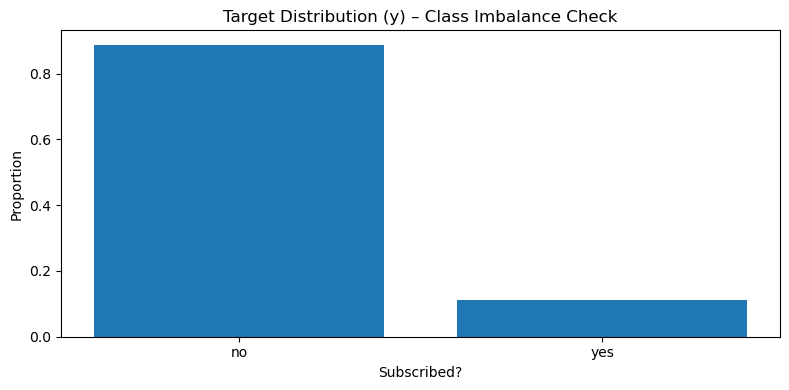

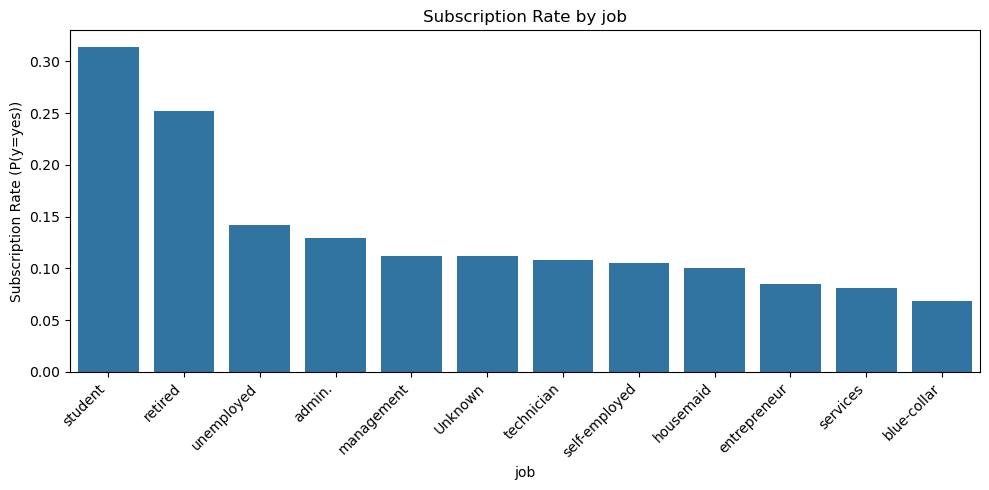

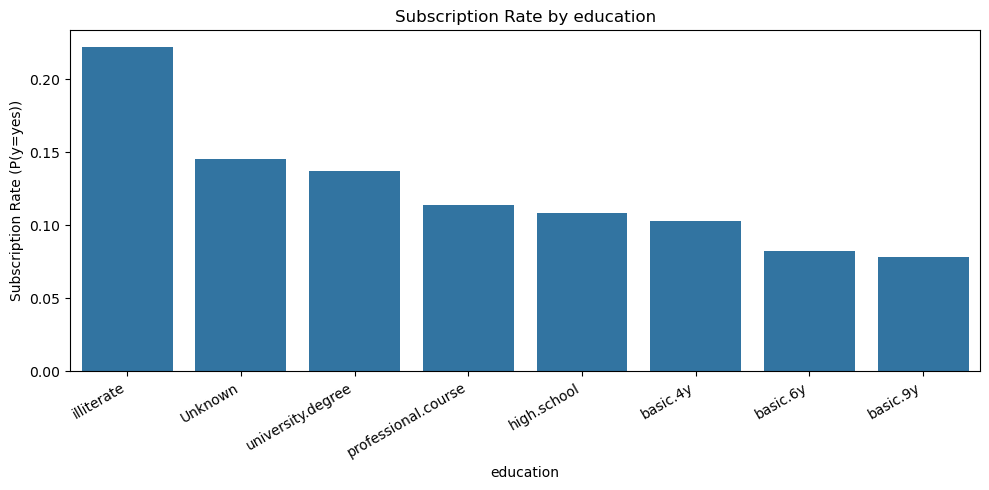

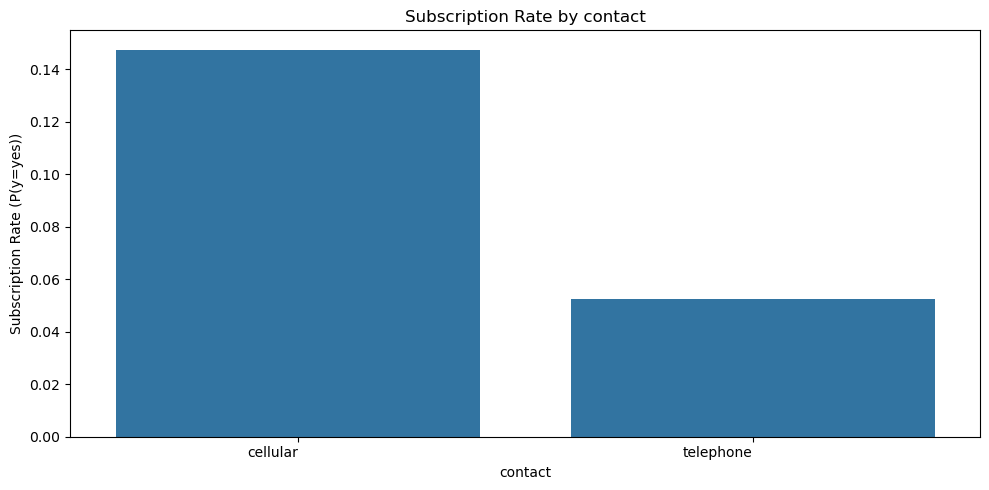

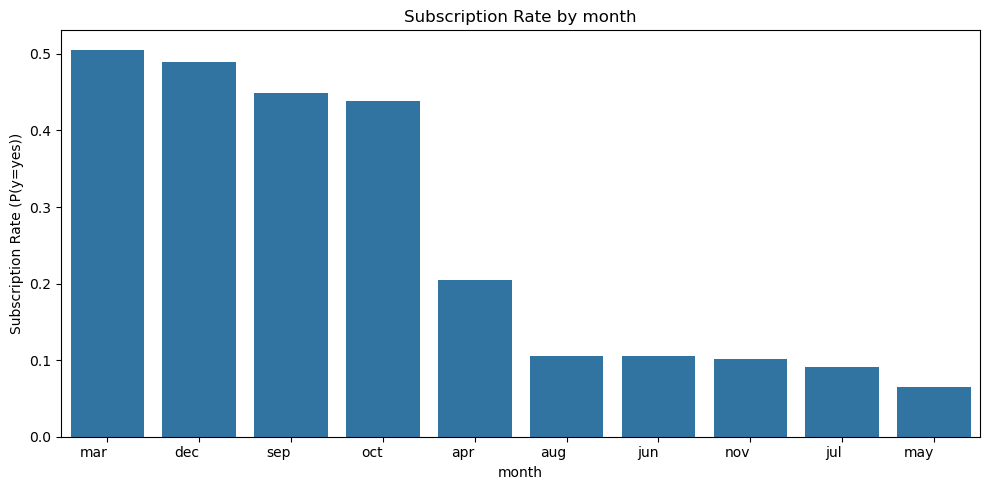

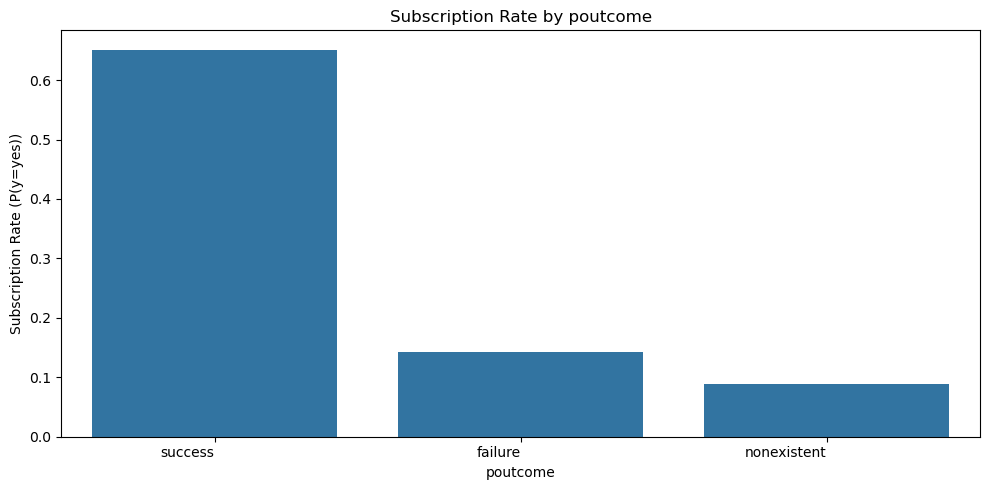

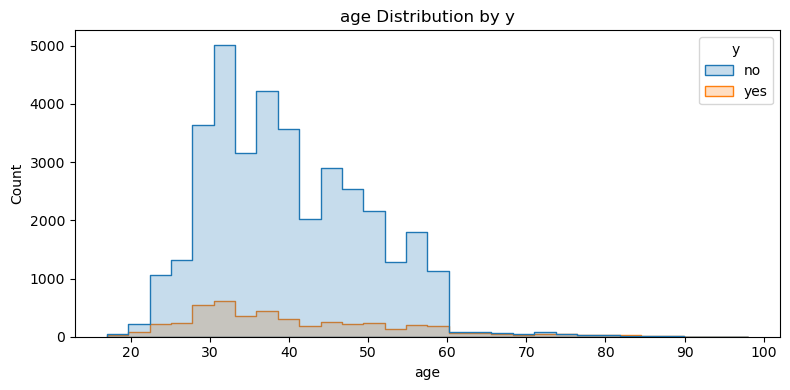

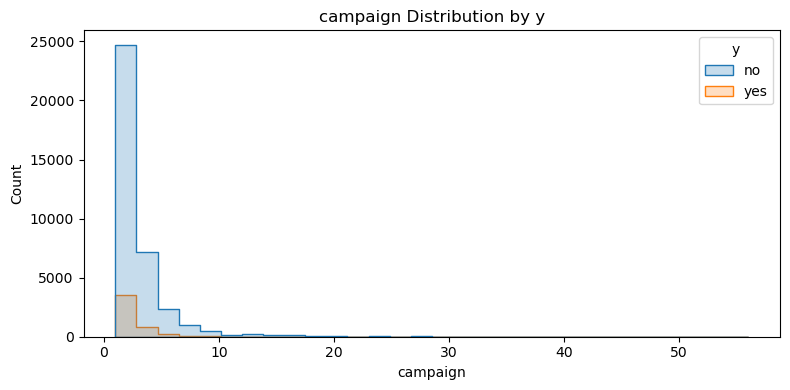

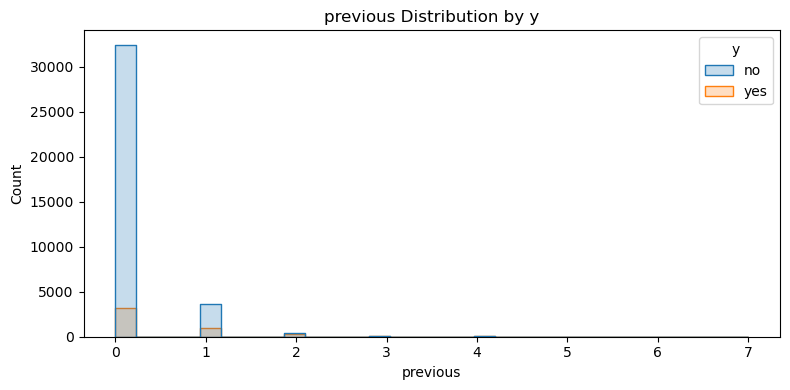

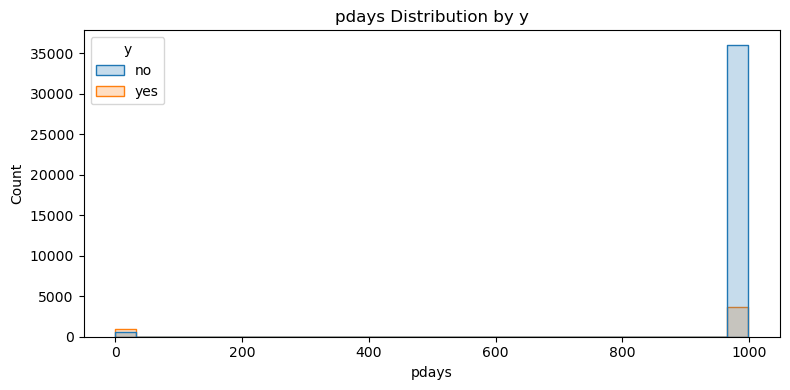

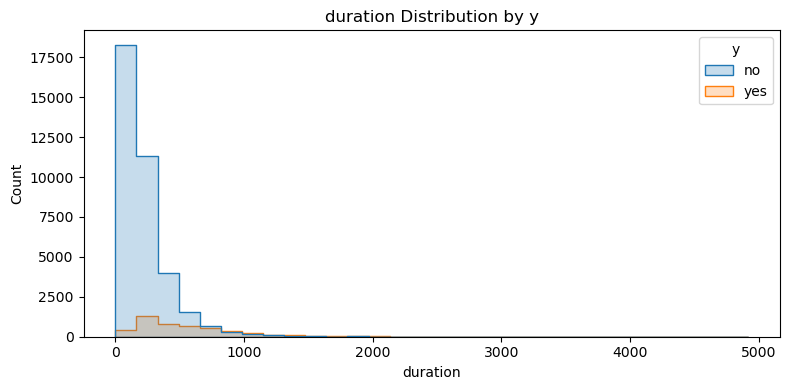

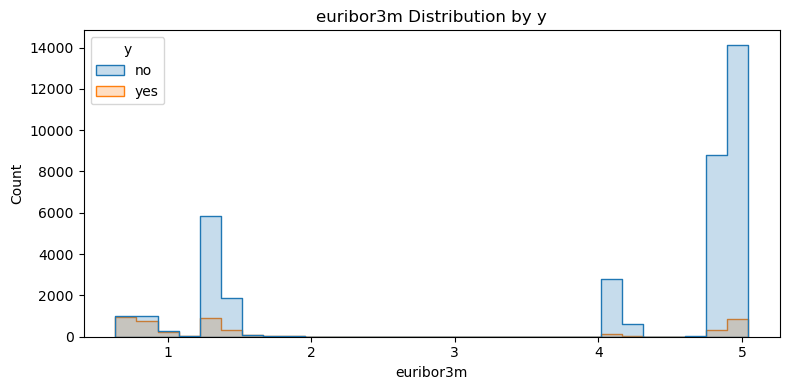

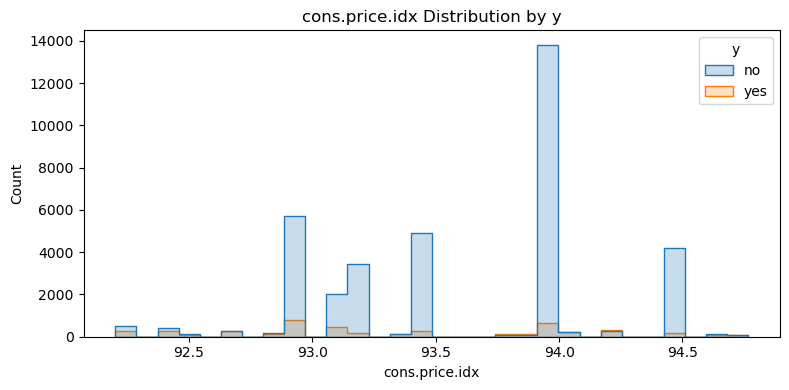

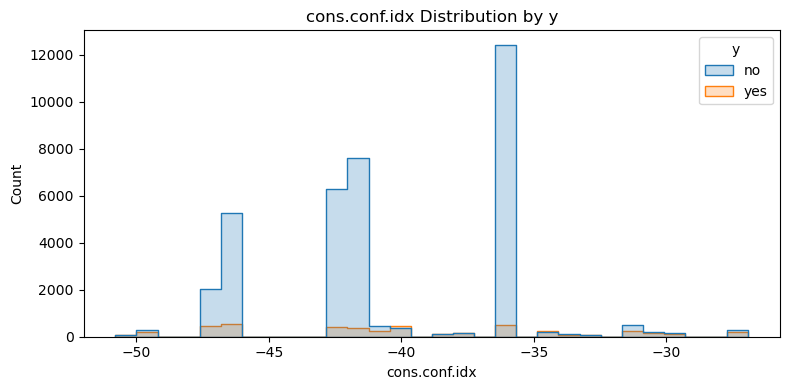


Subscription rate by age_group:
age_group
61+      0.454945
18-30    0.152242
46-60    0.095596
31-45    0.093656
Name: y_num, dtype: float64


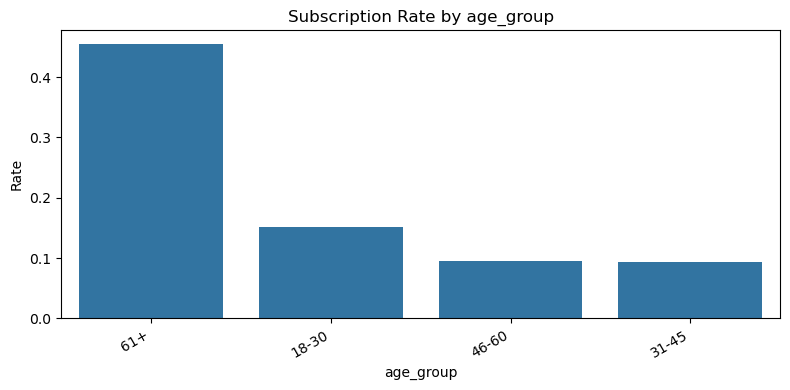


Subscription rate by campaign_group:
campaign_group
1 call       0.130371
2-3 calls    0.112187
4-6 calls    0.084911
7+ calls     0.046135
Name: y_num, dtype: float64


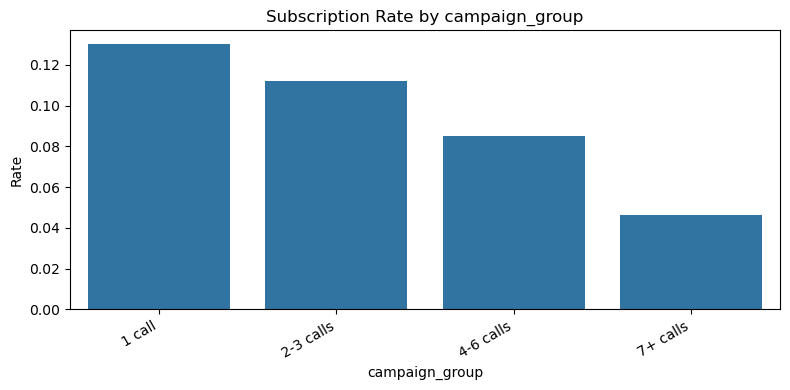


Train class distribution: {0: 0.8873444613050075, 1: 0.11265553869499241}
Test  class distribution: {0: 0.8873512988589464, 1: 0.11264870114105366}

=== Logistic Regression + SMOTE ===
Accuracy: 0.8254
ROC-AUC: 0.8005
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7310
           1       0.35      0.66      0.46       928

    accuracy                           0.83      8238
   macro avg       0.65      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238



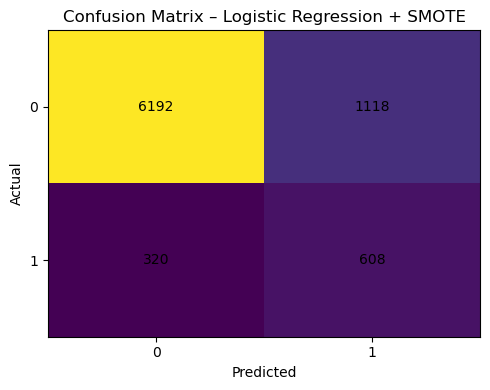

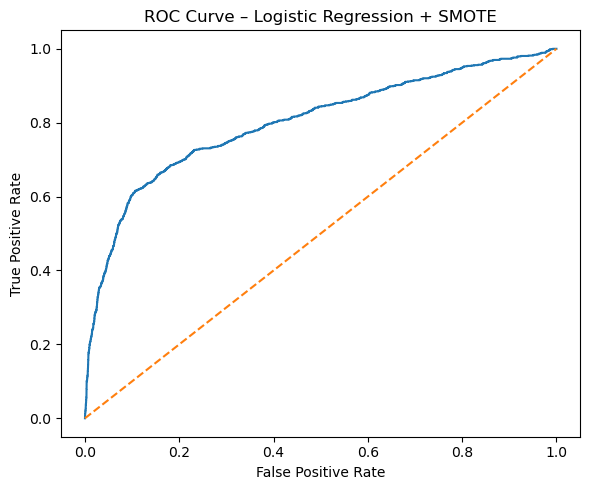

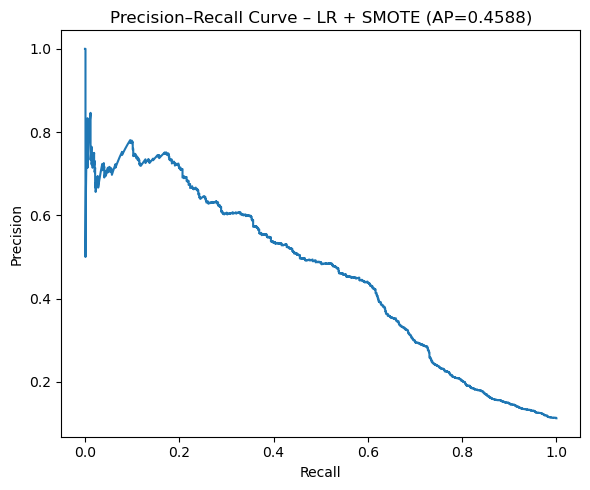


=== Random Forest + SMOTE ===
Accuracy: 0.8893
ROC-AUC: 0.7832
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      7310
           1       0.51      0.37      0.43       928

    accuracy                           0.89      8238
   macro avg       0.72      0.66      0.68      8238
weighted avg       0.88      0.89      0.88      8238



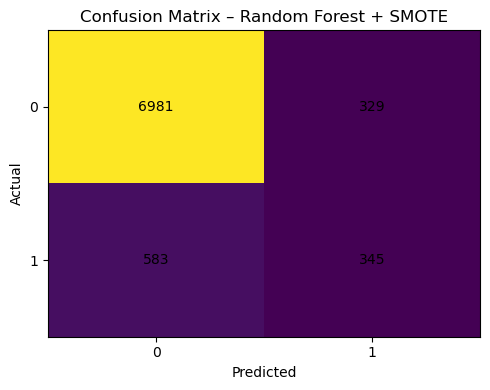

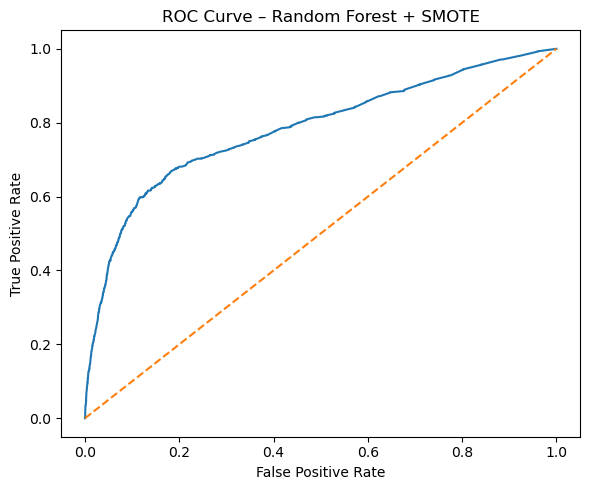

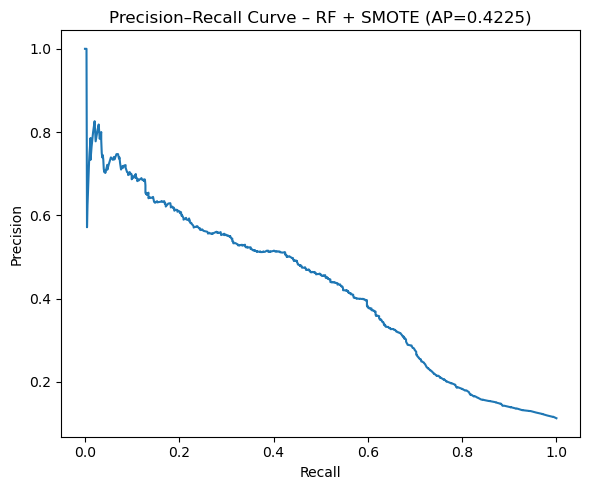


Top 20 Important Features (RF + SMOTE):
                        feature  importance
7                     euribor3m    0.115983
1                      campaign    0.090959
0                           age    0.072373
8                   nr.employed    0.059252
4                  emp.var.rate    0.053870
30                   default_no    0.044330
36            contact_telephone    0.035036
6                 cons.conf.idx    0.034188
46              day_of_week_mon    0.029102
49              day_of_week_wed    0.027267
47              day_of_week_thu    0.026032
5                cons.price.idx    0.025683
48              day_of_week_tue    0.025010
9                    job_admin.    0.020334
29  education_university.degree    0.018107
2                         pdays    0.017766
33                  housing_yes    0.017429
32                   housing_no    0.017281
51             poutcome_success    0.015869
42                    month_may    0.015721


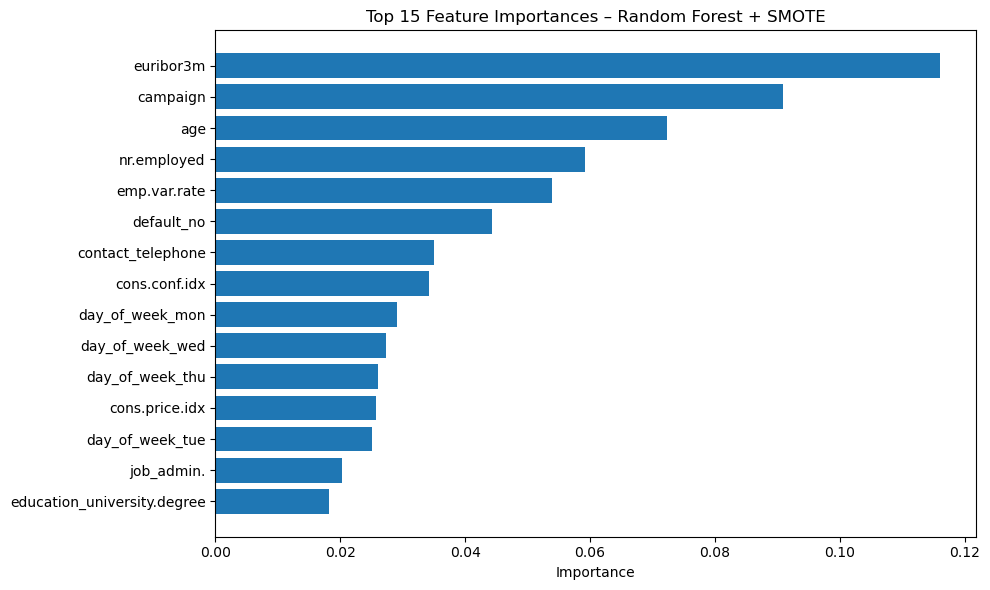


Top 10% Precision (RF + SMOTE): 0.497

Group Summary (Milestone 2):
- We loaded the bank marketing dataset and cleaned categorical "unknown" values by converting them to missing
  and then imputing them as "Unknown" to keep rows consistent.
- We confirmed class imbalance in the target variable and used SMOTE (training-only via imblearn pipeline)
  to balance the minority class for modeling.
- We performed EDA using both Matplotlib and Seaborn: target distribution, category subscription rates,
  and numeric distributions (including duration in EDA).
- We dropped 'duration' before modeling to avoid leakage since duration is known after the call ends.
- We trained a Logistic Regression baseline and a Random Forest model, and evaluated them with accuracy,
  ROC-AUC, confusion matrices, ROC curves, and Precision–Recall curves.
- We added customer segmentation (age, balance if available, and campaign frequency) and a top-10% targeting
  strategy to support real marketing decision-making.



In [1]:
#Predictive Engagement Modeling: Analyzing Churn and Subscription Propensity in Retail Banking 
#=============================================================================================
#GROUP members 
#Christian Shannon, Ashley Love, Mugtaba Awad, and Kristian Livingston
#=============================================================================================

# %% [Cell 1] Imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# imbalanced-learn (for SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# %% [Cell 2] Load dataset (we double-checked the separator is semicolon)
# Team note: Bank additional full dataset uses ";" not ",".
file_path = r"bank-additional-full.csv"  # <-- update if needed

try:
    df = pd.read_csv(file_path, sep=";")
except FileNotFoundError:
    raise FileNotFoundError(
        f"File not found at:\n{file_path}\n"
        "Fix the path (or move the CSV to that location) then run again."
    )

print("Preview (top rows):")
display(df.head()) if "display" in globals() else print(df.head())

print("\nShape:", df.shape)
print("\nInfo:")
print(df.info())

# %% [Cell 3] Quick data quality checks (missing + duplicates)
# Team note: In this dataset, "unknown" often appears instead of true missing NaN.
print("\nMissing values per column (NaN only):")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())

# %% [Cell 4] Clean 'unknown' values (draft requirement)
# Team note:
# The draft says we cleaned 'unknown' categories. Here we turn 'unknown' into NaN,
# then we will impute them as "Unknown" (so we don't drop rows).
df_clean = df.copy()

obj_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    df_clean[c] = df_clean[c].replace("unknown", np.nan)

# Impute categorical NaNs with "Unknown"
for c in obj_cols:
    df_clean[c] = df_clean[c].fillna("Unknown")

print("\nAfter cleaning 'unknown' -> NaN -> 'Unknown':")
print((df_clean[obj_cols] == "Unknown").sum().sort_values(ascending=False).head(10))

# %% [Cell 5] Target distribution (class imbalance visualization)
# Team note: Marketing datasets usually have fewer "yes" than "no".
target_counts = df_clean["y"].value_counts(normalize=True)

plt.figure(figsize=(8, 4))
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution (y) – Class Imbalance Check")
plt.ylabel("Proportion")
plt.xlabel("Subscribed?")
plt.tight_layout()
plt.show()

# %% [Cell 6] EDA (Seaborn + Matplotlib): categorical vs target
# Team note: We used seaborn here because it’s quick for clean plots.
def plot_cat_rate(feature, rotate=0):
    if feature not in df_clean.columns:
        return

    ct = pd.crosstab(df_clean[feature], df_clean["y"], normalize="index")
    yes_col = "yes" if "yes" in ct.columns else ct.columns[-1]
    ct = ct.sort_values(by=yes_col, ascending=False).reset_index()

    plt.figure(figsize=(10, 5))
    sns.barplot(data=ct, x=feature, y=yes_col)
    plt.title(f"Subscription Rate by {feature}")
    plt.ylabel("Subscription Rate (P(y=yes))")
    plt.xlabel(feature)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()

for col, rot in [("job", 45), ("education", 30), ("contact", 0), ("month", 0), ("poutcome", 0)]:
    plot_cat_rate(col, rotate=rot)

# %% [Cell 7] EDA: numeric distributions by target (and duration note)
# Team note:
# The draft hypothesis mentions call behavior (duration/frequency). We show duration in EDA,
# BUT we will drop duration BEFORE modeling to avoid leakage (duration is known after the call ends).
numeric_candidates = ["age", "campaign", "previous", "pdays", "duration", "euribor3m", "cons.price.idx", "cons.conf.idx"]
numeric_features = [c for c in numeric_candidates if c in df_clean.columns]

for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_clean, x=col, hue="y", bins=30, kde=False, element="step")
    plt.title(f"{col} Distribution by y")
    plt.tight_layout()
    plt.show()

# %% [Cell 8] Segmentation (draft requirement) – age + balance (if available) + campaign
# Team note: Segmentation helps translate the model into marketing actions.
df_seg = df_clean.copy()
df_seg["y_num"] = df_seg["y"].map({"yes": 1, "no": 0})

if "age" in df_seg.columns:
    df_seg["age_group"] = pd.cut(
        df_seg["age"], bins=[0, 30, 45, 60, 120],
        labels=["18-30", "31-45", "46-60", "61+"]
    )

# Some versions of the bank dataset do NOT have "balance". If yours doesn't, we skip it.
if "balance" in df_seg.columns:
    df_seg["balance_group"] = pd.qcut(
        df_seg["balance"], q=4,
        labels=["Low", "Mid-Low", "Mid-High", "High"]
    )

if "campaign" in df_seg.columns:
    df_seg["campaign_group"] = pd.cut(
        df_seg["campaign"], bins=[-1, 1, 3, 6, 100],
        labels=["1 call", "2-3 calls", "4-6 calls", "7+ calls"]
    )

def segment_rate_plot(col):
    if col not in df_seg.columns:
        return
    rates = df_seg.groupby(col)["y_num"].mean().sort_values(ascending=False)

    print(f"\nSubscription rate by {col}:")
    print(rates)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=rates.index.astype(str), y=rates.values)
    plt.title(f"Subscription Rate by {col}")
    plt.ylabel("Rate")
    plt.xlabel(col)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

segment_rate_plot("age_group")
segment_rate_plot("balance_group")
segment_rate_plot("campaign_group")

# %% [Cell 9] Leakage handling: drop 'duration' BEFORE modeling (best practice)
# Team note:
# We still discussed duration in EDA because it relates to call behavior,
# but for predictive modeling it leaks info (you only know duration after the call).
df_model = df_clean.drop(columns=["duration"]) if "duration" in df_clean.columns else df_clean.copy()

# %% [Cell 10] Prepare X/y (binary target)
X = df_model.drop(columns=["y"])
y = df_model["y"].map({"yes": 1, "no": 0})

# %% [Cell 11] Train-test split (stratify keeps class ratio stable)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain class distribution:", y_train.value_counts(normalize=True).to_dict())
print("Test  class distribution:", y_test.value_counts(normalize=True).to_dict())

# %% [Cell 12] Preprocessing (scale numeric + one-hot encode categorical)
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# %% [Cell 13] Baseline Model 1: Logistic Regression + SMOTE (draft requirement)
# Team note:
# SMOTE should ONLY be applied on the training data. Using imblearn Pipeline ensures that.
lr_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=2000))
])

lr_smote.fit(X_train, y_train)

y_pred_lr = lr_smote.predict(X_test)
y_prob_lr = lr_smote.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression + SMOTE ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_lr), 4))
print(classification_report(y_test, y_pred_lr))

# Confusion matrix plot (matplotlib)
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
plt.imshow(cm_lr, aspect="auto")
plt.title("Confusion Matrix – Logistic Regression + SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_lr[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# ROC curve (draft-aligned evaluation visuals)
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve – Logistic Regression + SMOTE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

# PR curve (useful with imbalance)
prec, rec, _ = precision_recall_curve(y_test, y_prob_lr)
ap = average_precision_score(y_test, y_prob_lr)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title(f"Precision–Recall Curve – LR + SMOTE (AP={ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# %% [Cell 14] Model 2: Random Forest + SMOTE (draft requirement)
# Team note:
# RF can handle imbalance with class_weight too, but the draft says SMOTE, so we use SMOTE here as well.
rf_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_smote.fit(X_train, y_train)

y_pred_rf = rf_smote.predict(X_test)
y_prob_rf = rf_smote.predict_proba(X_test)[:, 1]

print("\n=== Random Forest + SMOTE ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_rf), 4))
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
plt.imshow(cm_rf, aspect="auto")
plt.title("Confusion Matrix – Random Forest + SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_rf[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve – Random Forest + SMOTE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_test, y_prob_rf)
ap = average_precision_score(y_test, y_prob_rf)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title(f"Precision–Recall Curve – RF + SMOTE (AP={ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# %% [Cell 15] Feature importance (draft interpretability requirement)
# Team note:
# We extract feature names from preprocessing and match them to RF feature_importances_.
ohe = rf_smote.named_steps["preprocessor"].named_transformers_["cat"]
cat_names = list(ohe.get_feature_names_out(cat_cols))
all_feature_names = list(num_cols) + cat_names

rf_estimator = rf_smote.named_steps["model"]
importances = rf_estimator.feature_importances_

fi = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 20 Important Features (RF + SMOTE):")
print(fi.head(20))

top15 = fi.head(15).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top15["feature"], top15["importance"])
plt.title("Top 15 Feature Importances – Random Forest + SMOTE")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# %% [Cell 16] Top 10% high probability customers (marketing targeting metric)
# Team note:
# This connects the model to a real marketing action: target the top-likelihood clients.
results = X_test.copy()
results["actual"] = y_test.values
results["probability"] = y_prob_rf

top_10 = results.sort_values("probability", ascending=False).head(int(0.1 * len(results)))
top_10_precision = top_10["actual"].mean()

print("\nTop 10% Precision (RF + SMOTE):", round(top_10_precision, 4))

# %% [Cell 17] Student-style group summary (aligns with the draft narrative)
print("""
Group Summary (Milestone 2):
- We loaded the bank marketing dataset and cleaned categorical "unknown" values by converting them to missing
  and then imputing them as "Unknown" to keep rows consistent.
- We confirmed class imbalance in the target variable and used SMOTE (training-only via imblearn pipeline)
  to balance the minority class for modeling.
- We performed EDA using both Matplotlib and Seaborn: target distribution, category subscription rates,
  and numeric distributions (including duration in EDA).
- We dropped 'duration' before modeling to avoid leakage since duration is known after the call ends.
- We trained a Logistic Regression baseline and a Random Forest model, and evaluated them with accuracy,
  ROC-AUC, confusion matrices, ROC curves, and Precision–Recall curves.
- We added customer segmentation (age, balance if available, and campaign frequency) and a top-10% targeting
  strategy to support real marketing decision-making.
""")
